In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import torch
import cv2
import open3d as o3d

%matplotlib inline

# Specifying File paths

<class 'numpy.ndarray'> (1200, 1920, 3)


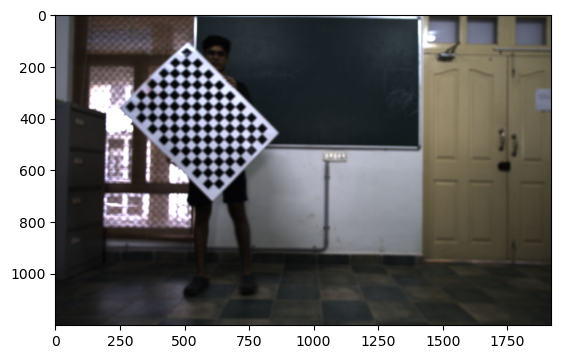

In [17]:
# specify the path of the folder where the sample data is present
image_folder = "/home/asl/Muni/workspace/matlab_scripts/extracted_right_cam_img_pcd/extracted_img/"
pcd_folder = "/home/asl/Muni/workspace/matlab_scripts/extracted_right_cam_img_pcd/extracted_pcd/"

# specify the file name, the image and PCD file must be of same frame
img_fname = "0020.png"
pcd_fname = "0020.pcd"

# reading the image 
testImage = img.imread(image_folder+img_fname)

# displaying the image 
plt.imshow(testImage)

print(type(testImage), testImage.shape)

<class 'numpy.ndarray'> (28754, 3)


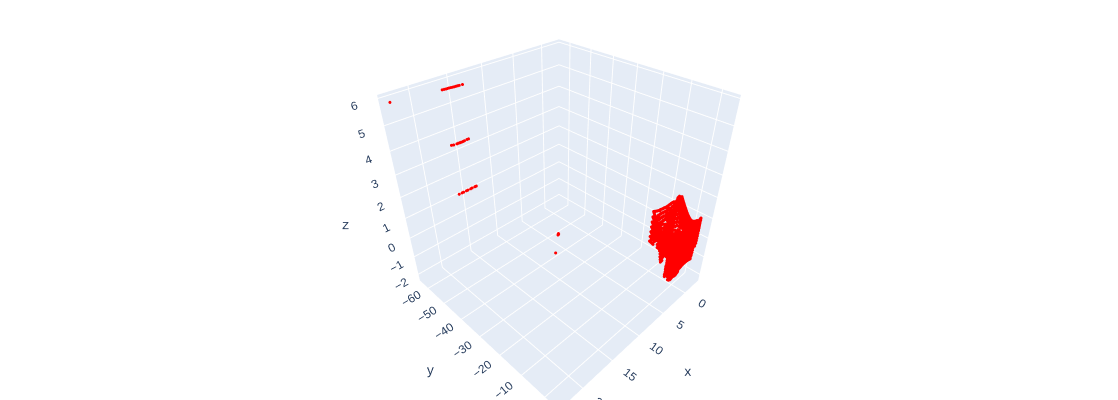

In [18]:
# display the point cloud
cloud = o3d.io.read_point_cloud(pcd_folder+pcd_fname)
arr_cloud = np.asarray(cloud.points)
# print(np.asarray(cloud.points))
print(type(arr_cloud), arr_cloud.shape)
# print(np.asarray(cloud.colors))import open3d as o3d; print(o3d.__version__)
# print(np.asarray(cloud.normals))

o3d.visualization.draw_plotly([cloud])

# visualizer = JVisualizer()
# visualizer.add_geometry(pcd)
# visualizer.show()



## Crop the point cloud to the positive Y axis where the camera FOV is present

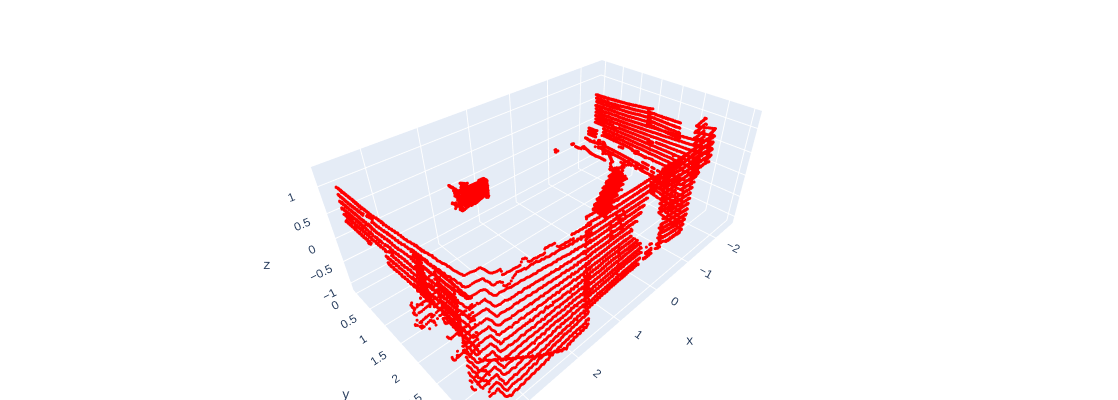

In [19]:
# filtered point cloud
filtered_pts = arr_cloud[arr_cloud[:,1] >= 0]
filtered_cloud = o3d.geometry.PointCloud()
filtered_cloud.points = o3d.utility.Vector3dVector(filtered_pts)
o3d.visualization.draw_plotly([filtered_cloud])

## Define the [R|T] matrix (i.e, Projection Matrix) for Lidar frame to Camera frame

#### This is called camera lidar calibration.The values are obatined by using Lidar-cam calibration application from Matlab

In [21]:
affine_mat = np.array([ [0.997644535011590,   0.031442232753677,	0.060965299646381, -0.498490339865991],
                        [0.058347302541604,	  0.078359269465220,	-0.995216266534564,	-0.412317415042402],
                        [-0.036069017835644,  0.996429230245852,	0.076340127482415,	-0.293245695639393],
                        [0                 ,  0,	                0,	                 1 ]])

In [22]:
affine_mat.shape

(4, 4)

In [23]:
# Load image
image = cv2.imread(image_folder+img_fname)

#check the image shape
print("image shape : ", image.shape)

# Load point cloud
point_cloud = o3d.io.read_point_cloud(pcd_folder+pcd_fname)

# Camera intrinsics, taken from the matlab results
K = np.array([[1.137500460364676e+03, 0,                    9.986003077684562e+02],
              [0,                     1.168334846782819e+03, 5.715431180694630e+02],
              [0,                     0,                     1]])

# Extrinsic parameters
R = affine_mat[:-1, :-1]

T = affine_mat[:-1, -1]
print("\nRotation Matrix : \n", R, "\n\nTranslation Matrix : \n", T)

# Transform point cloud i.e, make the point cloud to Homogenous coordinates [x, y, z, 1]
# points = np.asarray(point_cloud.points)
points = filtered_pts
points_homogeneous = np.hstack((points, np.ones((points.shape[0], 1))))  # Homogeneous coordinates

print(points_homogeneous.shape)

# Transformation matrix
extrinsics = np.eye(4)
extrinsics[:3, :3] = R
extrinsics[:3, 3] = T

print("\n\nAffine Transformation Matrix : \n",extrinsics)

# Transform the points to the Camera frame
camera_frame_homo_pts = []
for i in range(points_homogeneous.shape[0]):
    # matrix muliply and append each point
    # print("Extrinsic: ",extrinsics.shape, extrinsics, "\n Homogenous points : ", points_homogeneous[i].shape, points_homogeneous[i])
    res_pt = extrinsics @ points_homogeneous[i]
    # print("Resultatnta : ", res_pt.shape, res_pt[:-1])
    camera_frame_homo_pts.append(res_pt[:-1])

camera_frame_pts = np.array(camera_frame_homo_pts)

# print("\n\nCamera frame points : "camera_frame_pts.shape, "\nActual points : ", camera_frame_pts)
img_frame_pts = []
# project the points from camera coordinate system onto the image plane
for i in range(camera_frame_pts.shape[0]):
    res_pt = K @ camera_frame_pts[i]
    res_pt = res_pt/res_pt[-1]         # Normalize to make the last term to 1
    # print("Inttrinsic: ",K.shape, K, "\n Homogenous points : ", camera_frame_pts[i].shape, camera_frame_pts[i])
    # print("Resultant : ", res_pt.shape, res_pt)
    img_frame_pts.append(res_pt[:-1])

img_frame_pts = np.array(img_frame_pts)
print("Final points size : ", img_frame_pts.shape)

# at each point cloud point in the camera frame draw a circle
for pt in img_frame_pts:
    # print("Points : ", pt)
    x, y = int(pt[0]), int(pt[1])
    if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

cv2.imshow('Overlay', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Press alt to close the window

'''
# Transform points to camera coordinate system
points_camera = points_homogeneous @ extrinsics.T

# Project points onto image plane
points_camera = points_camera[:, :3]  # Drop homogeneous coordinate
points_image = (K @ points_camera.T).T  # Apply intrinsics
points_image = points_image[:, :2] / points_image[:, 2:3]  # Normalize points

# Overlay points on the image
for point in points_image:
    x, y = int(point[0]), int(point[1])
    if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

# Show the image with overlaid points
cv2.imshow('Overlay', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

image shape :  (1200, 1920, 3)

Rotation Matrix : 
 [[ 0.99764454  0.03144223  0.0609653 ]
 [ 0.0583473   0.07835927 -0.99521627]
 [-0.03606902  0.99642923  0.07634013]] 

Translation Matrix : 
 [-0.49849034 -0.41231742 -0.2932457 ]
(14607, 4)


Affine Transformation Matrix : 
 [[ 0.99764454  0.03144223  0.0609653  -0.49849034]
 [ 0.0583473   0.07835927 -0.99521627 -0.41231742]
 [-0.03606902  0.99642923  0.07634013 -0.2932457 ]
 [ 0.          0.          0.          1.        ]]
Final points size :  (14607, 2)


"\n# Transform points to camera coordinate system\npoints_camera = points_homogeneous @ extrinsics.T\n\n# Project points onto image plane\npoints_camera = points_camera[:, :3]  # Drop homogeneous coordinate\npoints_image = (K @ points_camera.T).T  # Apply intrinsics\npoints_image = points_image[:, :2] / points_image[:, 2:3]  # Normalize points\n\n# Overlay points on the image\nfor point in points_image:\n    x, y = int(point[0]), int(point[1])\n    if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:\n        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)\n\n# Show the image with overlaid points\ncv2.imshow('Overlay', image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n"